# 1. Data preprocessing and visualisations
## Importing libraries and datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
train_df=pd.read_csv('Datasets/train.csv')
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Data description
After eyeballing the above data, it is clear that the first column which is the action is our target variable. Let us check what each of the columns actually mean.

Column Name	Description

**ACTION**	ACTION is 1 if the resource was approved, 0 if the resource was not

**RESOURCE**	An ID for each resource

**MGR_ID**	The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time

**ROLE_ROLLUP_1**	Company role grouping category id 1 (e.g. US Engineering)

**ROLE_ROLLUP_2**	Company role grouping category id 2 (e.g. US Retail)

**ROLE_DEPTNAME**	Company role department description (e.g. Retail)

**ROLE_TITLE**	Company role business title description (e.g. Senior Engineering Retail Manager)

**ROLE_FAMILY_DESC**	Company role family extended description (e.g. Retail Manager, Software Engineering)

**ROLE_FAMILY**	Company role family description (e.g. Retail Manager)

**ROLE_CODE**	Company role code; this code is unique to each role (e.g. Manager)

Let us separate out the action column into another dataframe called the target_df.

In [3]:
target_df=pd.DataFrame(train_df['ACTION'],columns=['ACTION'])

In [4]:
target_df['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

As we can see, majority of the entries had the resources approved. Let us visualise this using a barplot.

Text(0.5, 1.0, 'Action distributions')

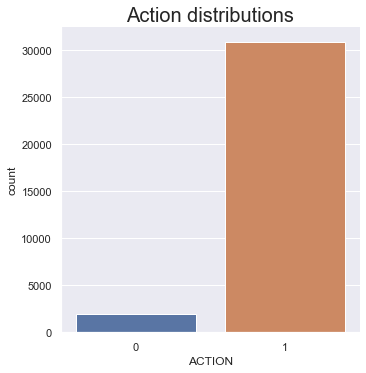

In [5]:
sns.catplot('ACTION',data=target_df,kind='count')
plt.title('Action distributions',size=20)

Let us check the various data types in the dataframe presented to us.

In [6]:
train_df.dtypes

ACTION              int64
RESOURCE            int64
MGR_ID              int64
ROLE_ROLLUP_1       int64
ROLE_ROLLUP_2       int64
ROLE_DEPTNAME       int64
ROLE_TITLE          int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object

As we can see, all the data is in integer form. This is extremely helpful for machine learning purpose as it doesn't require any further feature engineering or preprocessing to be done.

Infact, it could be said that most of the preprocessing was already done for us. This is because although we have many categorical features, the data is in integer form. This suggests that the categorical data that we have is already label or ordinal encoded for us.


Let us check if we have any missing variables to be take care of.

In [7]:
train_df.isna().any()

ACTION              False
RESOURCE            False
MGR_ID              False
ROLE_ROLLUP_1       False
ROLE_ROLLUP_2       False
ROLE_DEPTNAME       False
ROLE_TITLE          False
ROLE_FAMILY_DESC    False
ROLE_FAMILY         False
ROLE_CODE           False
dtype: bool

As we can see, we have no particular missing values at all in the dataframe. Hence, it can be said that the dataframe is already preprocessed with removal of all the missing values.

This means we can directly head towards machine learning.

In [8]:
train_df.drop('ACTION',axis=1,inplace=True)

# 2. Machine Learning

## KNN

Initially, let us use the KNearestNeighbor classifier to see how it classifies the ACTION correctly. For our classification, we will use a range of K values from 1 to 12.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,roc_curve,precision_recall_curve,auc


In [10]:
param_grid={'n_neighbors':[3,5,7]}
knn=KNeighborsClassifier()

In [11]:
X=train_df.values
y=target_df['ACTION'].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [12]:
grid_search=GridSearchCV(knn,param_grid,scoring='roc_auc')

In [13]:
grid_result=grid_search.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [14]:
grid_result.best_params_

{'n_neighbors': 7}

In [15]:
grid_result.score(X_train,y_train)

0.9259058489200512

However, to dig deeper into what value of K will be good, let us make a graph of accuracy Vs K for better understanding.

In [16]:
scores=[]
for i in range(1,13):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    cv_scores=cross_val_score(knn,X,y,cv=15)
    scores.append(cv_scores.mean())
    

([<matplotlib.axis.XTick at 0x7fd6a553c3d0>,
 <a list of 12 Text major ticklabel objects>)

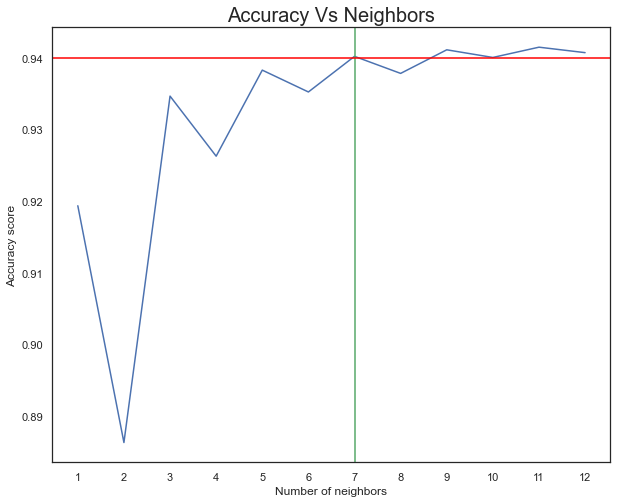

In [17]:
neighbors=np.arange(1,13)
plt.figure(figsize=(10,8))
sns.set(style='white')
plt.plot(neighbors,scores,color='b')
plt.axvline(7,color='g')
plt.axhline(0.94,color='red')
plt.title('Accuracy Vs Neighbors',size=20)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy score')
ticks=np.arange(1,13)
plt.xticks(ticks)

From the above graph, it is clear that at **N neighbors=7** , the accuracy is quite high. This was confirmed by the GridSearchCV aswell. We try not to exceed 7 neighbors even if the accuracy is slightly increasing. Too many neighbors lead to underfitting of the data.

Let us now make the predictions on the test dataset.

In [18]:
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
y_knn_pred=knn.predict(X_test)

In [19]:
knn_score=knn.score(X_test,y_test)
knn_score

0.9420201403722918

Text(30.5, 0.5, 'Actual')

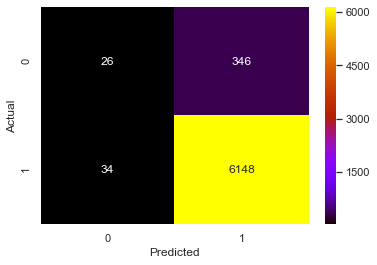

In [21]:
conf_mat_knn=confusion_matrix(y_test,y_knn_pred)
sns.heatmap(conf_mat_knn,annot=True,fmt='g',cmap='gnuplot')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## SVM

In [24]:
from sklearn.svm import SVC

In [27]:
svm=SVC(gamma=1e-07,C=1e9)
svm.fit(X_train,y_train)

SVC(C=1000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
svm.score(X_train,y_train)

0.9993133702078962

In [29]:
y_pred_svc=svm.predict(X_test)
svm.score(X_test,y_test)

0.9185230393652731

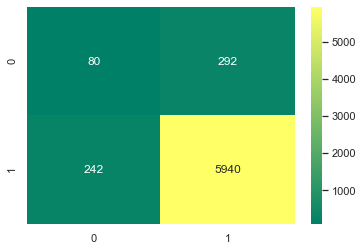

In [33]:
conf_mat_svc=confusion_matrix(y_test,y_pred_svc)
sns.heatmap(conf_mat_svc,annot=True,fmt='g',cmap='summer')

Let us check how the Reciever operating characteristic curve and Precision recall curve look like.

In [34]:
y_svc=svm.fit(X_train,y_train).decision_function(X_test)

Text(0.5, 1.0, 'ROC curve for SVC with AUC: 0.62')

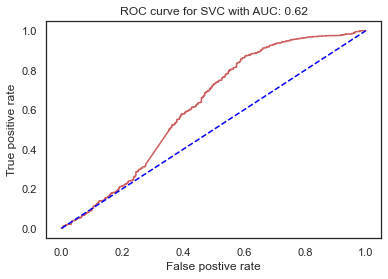

In [46]:
fpr,tpr,_=roc_curve(y_test,y_svc)
plt.plot(fpr,tpr,color='indianred')
plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel('False postive rate')
plt.ylabel('True positive rate')
auc_svc=auc(fpr,tpr)
plt.title('ROC curve for SVC with AUC: {0:.2f}'.format(auc_svc))

As we can see, the area under curve is only 0.62. This shows that the model is performing **quite average** .


Let us see how the precision-recall curve looks like.

Text(0, 0.5, 'Recall')

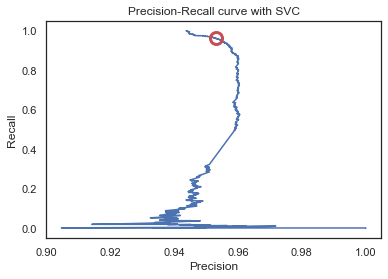

In [48]:
precision,recall,threshold=precision_recall_curve(y_test,y_svc)
closest_zero=np.argmin(np.abs(threshold))
closest_zero_p=precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.plot(precision,recall)
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.title('Precision-Recall curve with SVC')
plt.xlabel('Precision')
plt.ylabel('Recall')

The red dot above shows the optimum precision and recall value balance.

## Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [53]:
reg_log=LogisticRegression()

In [54]:
reg_log.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

As we can see, the model will implement a L2 regularisation (or penalty) for each incorrect prediction.

In [57]:
reg_log.score(X_train,y_train)

0.9418271981689872

In [56]:
y_pred_log=reg_log.predict(X_test)
reg_log.score(X_test,y_test)

0.9432407689960329

Text(30.5, 0.5, 'Actual')

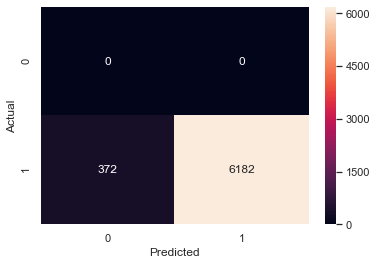

In [60]:
conf_mat_log=confusion_matrix(y_pred_log,y_test)
sns.heatmap(conf_mat_log,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

As we can see, the logistic regression could not capture any of the targets with 0 (or access denied). This clearly indicates that the model is only accurate at capturing the 1s.

In [61]:
y_log=reg_log.fit(X_train,y_train).decision_function(X_test)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 1.0, 'ROC curve for Logistic regression with AUC: 0.54')

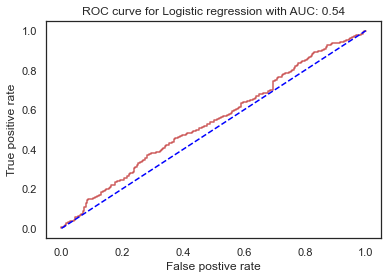

In [77]:
fpr,tpr,_=roc_curve(y_test,y_log)
plt.plot(fpr,tpr,color='indianred')
plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel('False postive rate')
plt.ylabel('True positive rate')
auc_svc=auc(fpr,tpr)
plt.title('ROC curve for Logistic regression with AUC: {0:.2f}'.format(auc_svc))

This is another extremely poor model as shown by the above ROC curve. This was already indicated by the confusion matrix.

## Stochastic gradient descent

In [65]:
from sklearn.linear_model import SGDClassifier

In [66]:
sgd=SGDClassifier()

In [67]:
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
sgd.score(X_train,y_train)

0.9418271981689872

In [69]:
y_pred_sgd=sgd.predict(X_test)
sgd.score(X_test,y_test)

0.9432407689960329

Text(30.5, 0.5, 'Actual')

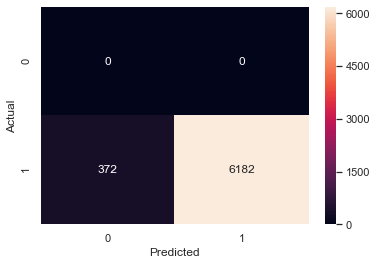

In [72]:
conf_mat_sgd=confusion_matrix(y_pred_sgd,y_test)
sns.heatmap(conf_mat_sgd,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

As we can see, the results are exactly same as the logistic regression model. Hence, no improvements could be seen using SGD.

Text(0.5, 1.0, 'ROC curve for SGD with AUC: 0.49')

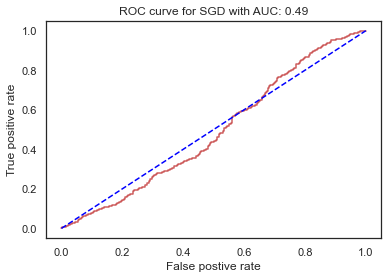

In [75]:
y_sgd=sgd.fit(X_train,y_train).decision_function(X_test)
fpr,tpr,_=roc_curve(y_test,y_sgd)
plt.plot(fpr,tpr,color='indianred')
plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel('False postive rate')
plt.ylabel('True positive rate')
auc_svc=auc(fpr,tpr)
plt.title('ROC curve for SGD with AUC: {0:.2f}'.format(auc_svc))

From the ROC, it is clearly visible how poor the model is predicting. In fact, it has performed poorer than Logistic regression with lower AUC and the line venturing below the blue threshold into the false positive region.